# Define the patch extraction strategy and test it

In [1]:
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
import torchvision.transforms as transforms

### Show a typical input

tensor([True, True, True])
tensor([1., 0., 0., 1.])
tensor([[0., 1., 0., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])


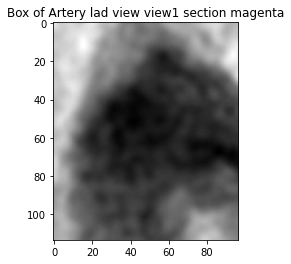

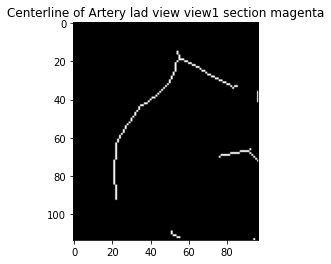

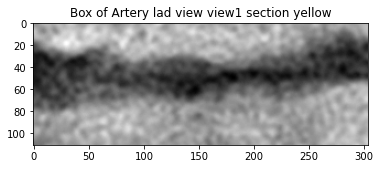

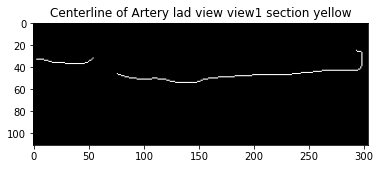

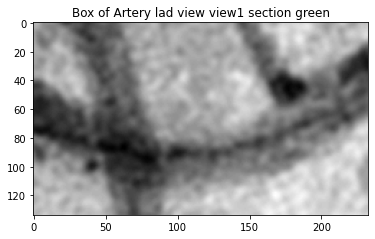

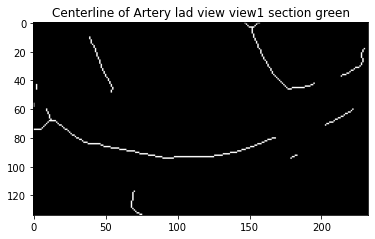

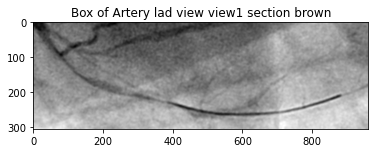

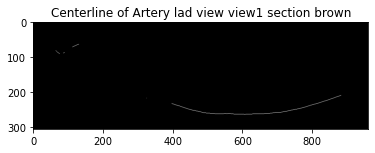

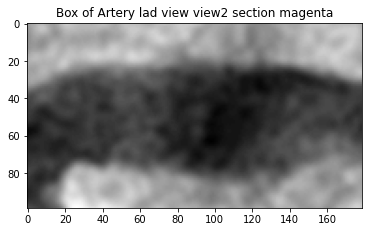

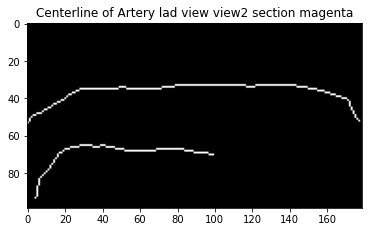

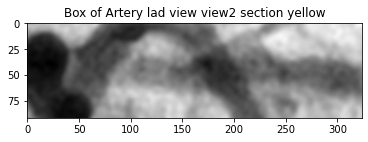

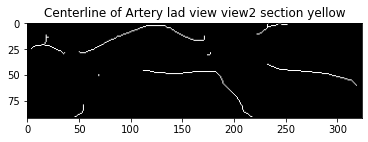

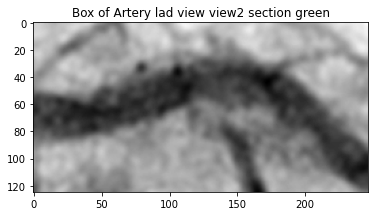

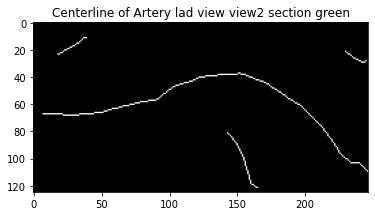

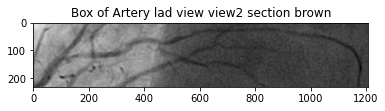

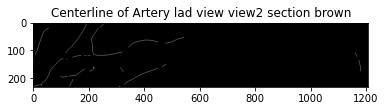

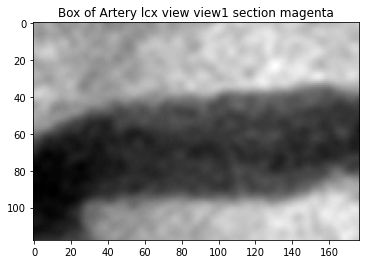

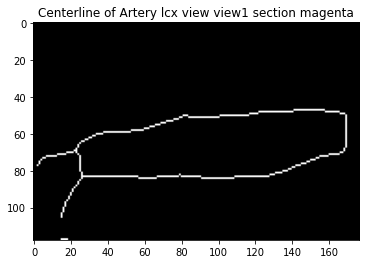

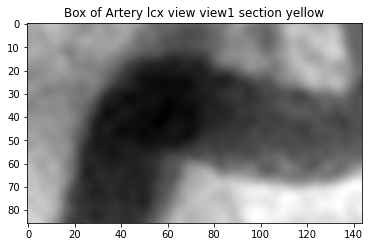

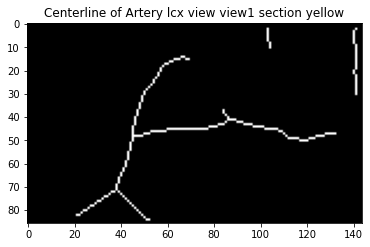

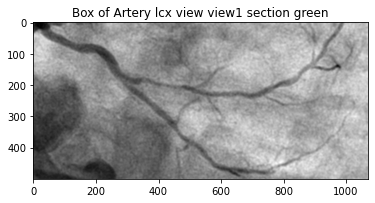

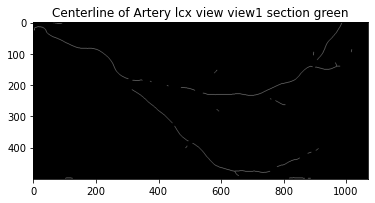

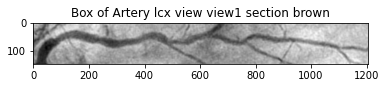

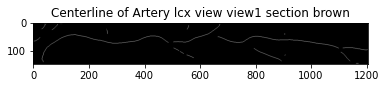

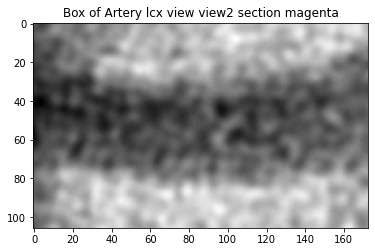

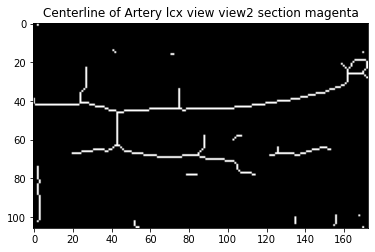

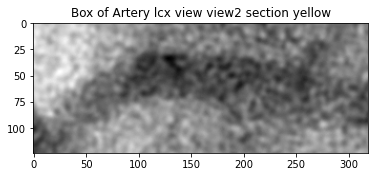

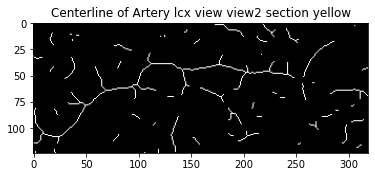

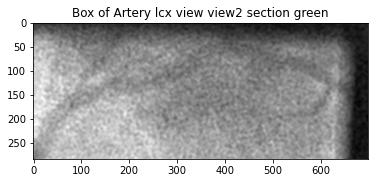

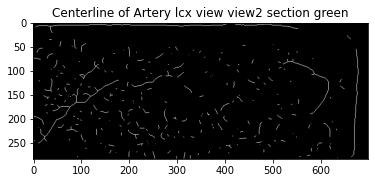

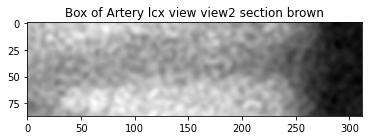

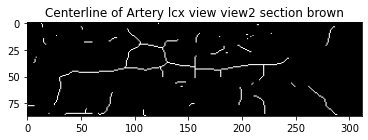

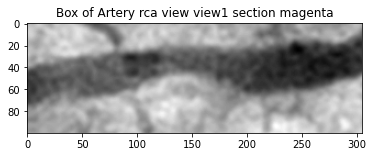

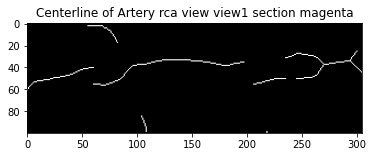

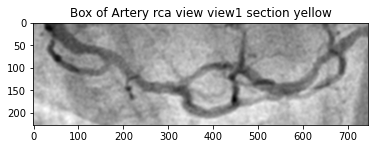

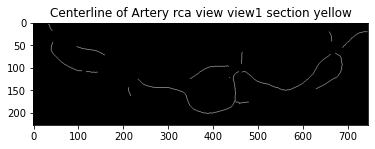

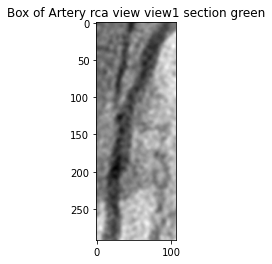

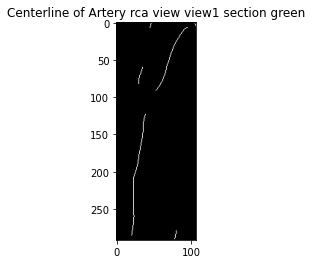

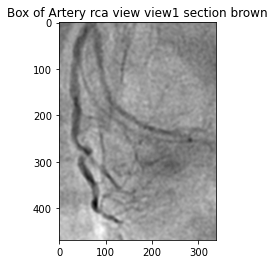

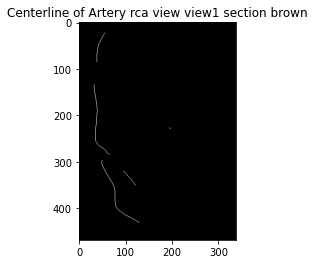

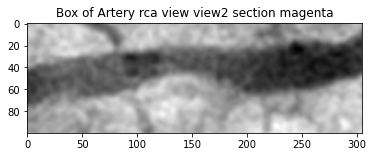

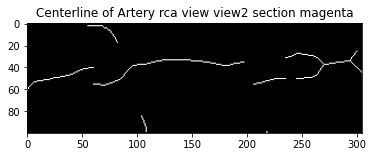

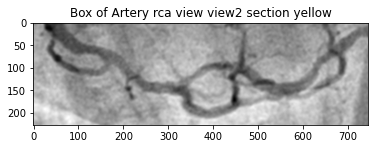

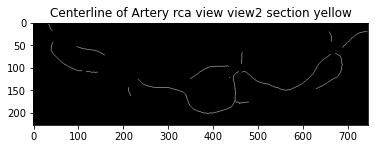

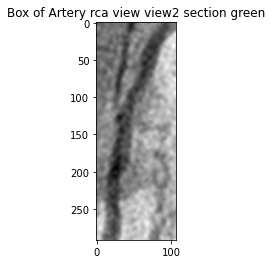

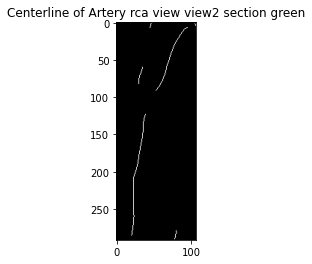

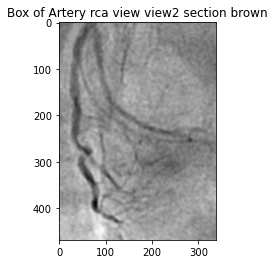

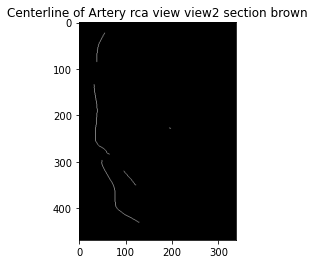

In [2]:
basepath = "transformer_patient_torch_tensors"
patient_name = "patient21"
    
available_arteries = torch.load(basepath+"/"+patient_name+"/available_arteries.pt")
print(available_arteries)
mi = torch.load(basepath+"/"+patient_name+"/global_mi.pt")
print(mi)
mi_all_boxes = torch.load(basepath+"/"+patient_name+"/mi_all_boxes.pt")
print(mi_all_boxes)

all_boxes = [[[[[[]] for l in range(0,2)] for k in range(0,2)] for j in range(0,4)] for i in range(0,3)]

for i_artery, artery in enumerate(["lad", "lcx", "rca"]):
    if available_arteries[i_artery]:
        for i_view, view in enumerate(["view1", "view2"]):
            for i_sect, section in enumerate(["magenta", "yellow", "green", "brown"]):

                box = torch.load(basepath+"/"+patient_name+"/"+artery+"_"+view+"_"+section+"_box.pt")
                centerline = torch.load(basepath+"/"+patient_name+"/"+artery+"_"+view+"_"+section+"_centerline.pt")

                all_boxes[i_artery][i_sect][i_view][0] = box
                all_boxes[i_artery][i_sect][i_view][1] = centerline

                plt.imshow(box, cmap="gray")
                plt.title("Box of Artery {} view {} section {}".format(artery, view, section))
                plt.show()

                plt.imshow(centerline, cmap="gray")
                plt.title("Centerline of Artery {} view {} section {}".format(artery, view, section))
                plt.show()

# Define patch extraction strategy

In [58]:
def extract_patches(img, img_mask, patch_size, nb_patch, rnd=0, debug=False):
    patches = []
    
    img_shape = img.shape
    
    # If the patch is too big, extract a smaller one
    reduction_ratio = 1
    while patch_size >= img_shape[0]//2 or patch_size >= img_shape[1]//2:
        patch_size //= 2
        reduction_ratio *= 2
    
    # Do not extract on the border
    img_mask[:, :int(patch_size/2)] = 0
    img_mask[:int(patch_size/2), :] = 0
    img_mask[int(-patch_size/2):, :] = 0
    img_mask[:, int(-patch_size/2):] = 0
    
    # Select uniformly (+ some noise) the position of the extracted patches
    x_line = np.linspace(start=patch_size//2+1, stop=img_shape[1]-patch_size-1, num=nb_patch)
    x_line += (patch_size//2-1)*(np.random.rand(nb_patch))
    
    if debug:
        fig, ax = plt.subplots()
        ax.imshow(img, cmap=cm.gray)
        proba_dist_plt = np.copy(img_mask)
        proba_dist_plt = 255*proba_dist_plt/np.max(proba_dist_plt)
        proba_dist_plt[proba_dist_plt>0] = 255
        ax.imshow(proba_dist_plt, cmap=cm.gray, interpolation='none', alpha=0.5)
        ax.set_title("Proba distribution")
            
    for i in range(0, nb_patch):
        width_pos = int(x_line[i])
        proba_line = img_mask[:,width_pos].numpy() # for some reason choice does not work with tensor
        
        if random.random() < rnd:
            height_pos = patch_size//2+1+int((img_shape[0]-patch_size-1)*random.random())
        else:
            if np.sum(proba_line)  == 0:
                height_pos = patch_size//2+1+int((img_shape[0]-patch_size-1)*random.random())
            else:
                proba_line /= np.sum(proba_line)
                height_pos = np.random.choice(img_shape[0], p=proba_line)

        if debug:
            plt.plot(width_pos, height_pos, 'ro')
            plt.vlines(width_pos, 0, img_shape[0]-1, colors="red", linestyles="--")

        extracted_patch = img[int(height_pos-patch_size/2):int(height_pos+patch_size/2), 
                                        int(width_pos-patch_size/2):int(width_pos+patch_size/2)]
        
        if reduction_ratio != 1:
            resizer = transforms.Resize(extracted_patch.shape[0]*reduction_ratio)
            extracted_patch = resizer(extracted_patch.unsqueeze(0).unsqueeze(0))[0,0,:,:]
        
        patches.append(extracted_patch)
        
    if debug:
        plt.title("Patches center position")
        plt.show()
        
    if debug:
        fig, axs = plt.subplots(1, nb_patch)
        for i, patch in enumerate(patches):
            axs[i].imshow(patch, cmap="gray")
            axs[i].set_axis_off()
        fig.tight_layout()
        fig.show()
        plt.show()
        
    return patches

### Show an example

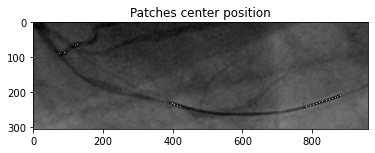

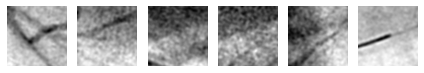

In [59]:
i_art, i_sect, i_view = 0, 3, 0
_ = extract_patches(all_boxes[i_art][i_sect][i_view][0], all_boxes[i_art][i_sect][i_view][1], 128, 6, rnd=0.0, debug=True)

# Automatise it for all infos

In [72]:
def extract_all_patches(available_arteries, patient_images, patch_size_l, nb_patch_l, rnd=0, debug=False):
    all_patches = [[[] for k in range(0,2)] for i in range(0,3)]
    
    for i_art, artery in enumerate(["LAD", "LCX", "RCA"]):
        for i_view in range(0,2):
            if available_arteries[i_art]:
                for i_sect, section in enumerate(["magenta", "yellow", "green", "brown"]):
                    if not all_patches[i_art][i_view]:
                        all_patches[i_art][i_view] = extract_patches(patient_images[i_art][i_sect][i_view][0], 
                                                                 patient_images[i_art][i_sect][i_view][1], 
                                                                 patch_size_l[i_sect], nb_patch_l[i_sect], 
                                                                 rnd=rnd, debug=debug)
                    else:
                        all_patches[i_art][i_view] += extract_patches(patient_images[i_art][i_sect][i_view][0], 
                                                                 patient_images[i_art][i_sect][i_view][1], 
                                                                 patch_size_l[i_sect], nb_patch_l[i_sect], 
                                                                 rnd=rnd, debug=debug)
            else:
                all_patches[i_art][i_view] = None

    return all_patches

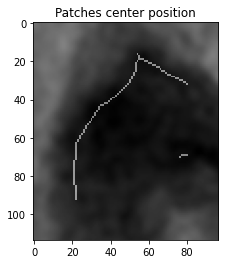

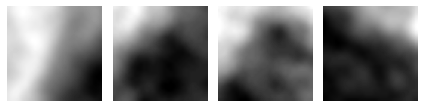

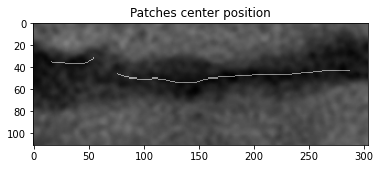

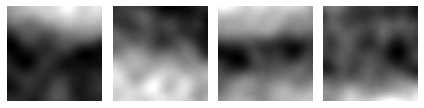

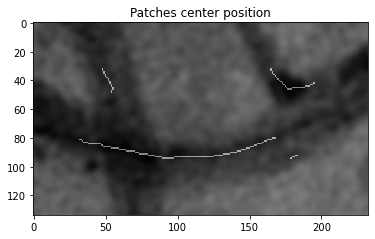

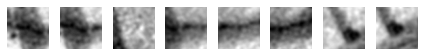

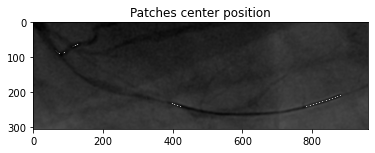

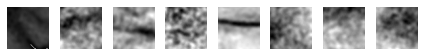

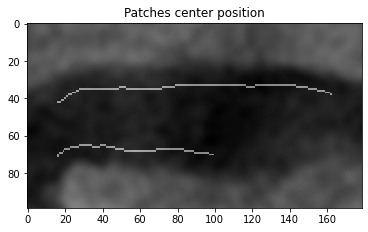

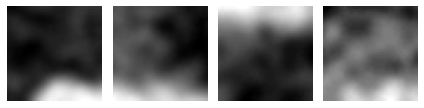

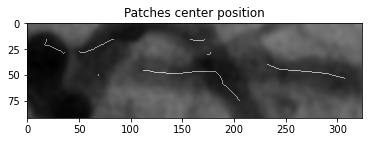

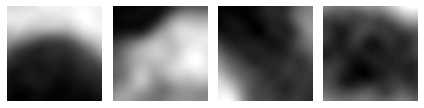

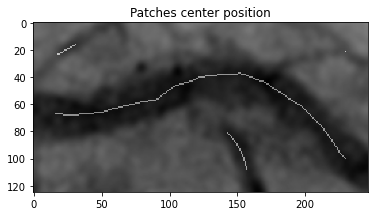

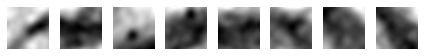

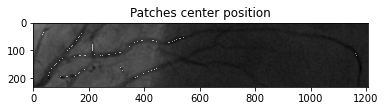

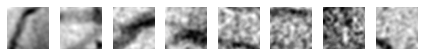

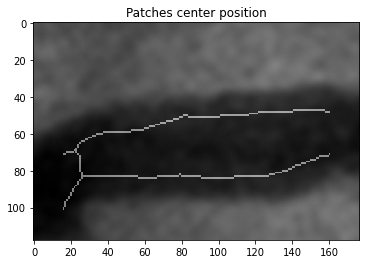

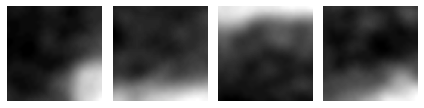

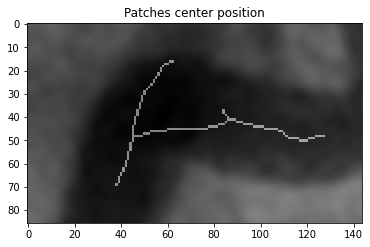

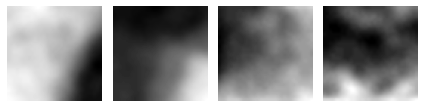

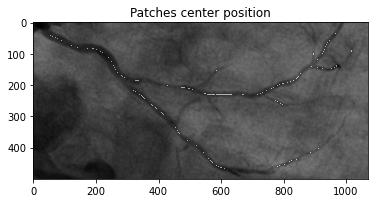

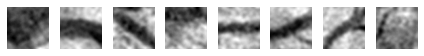

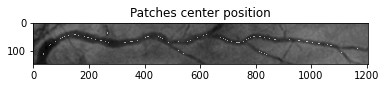

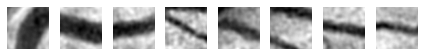

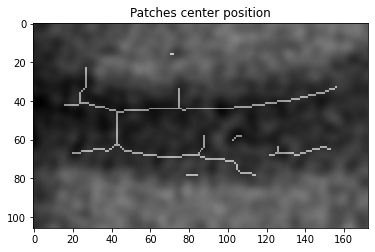

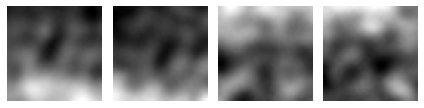

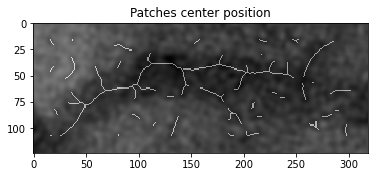

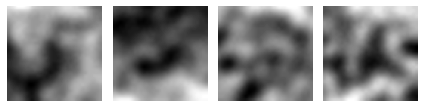

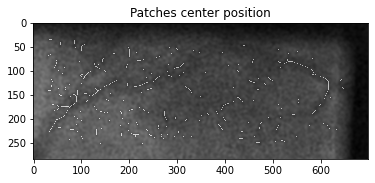

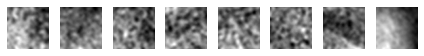

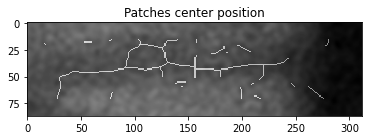

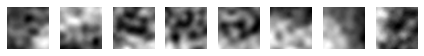

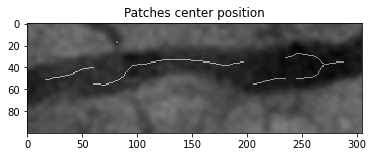

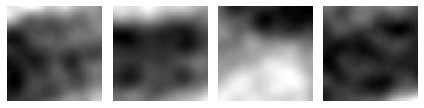

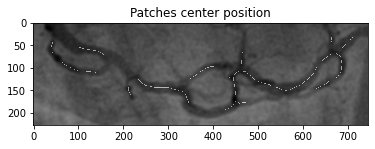

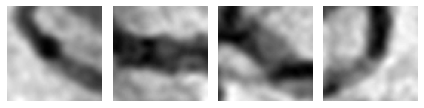

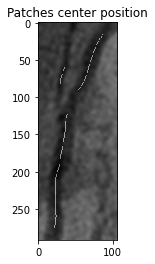

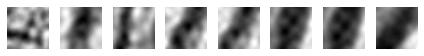

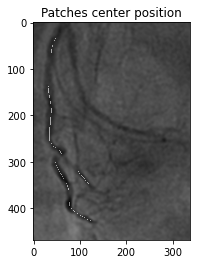

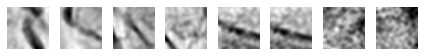

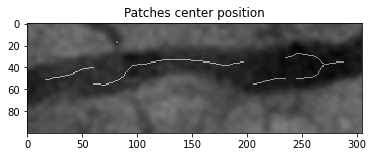

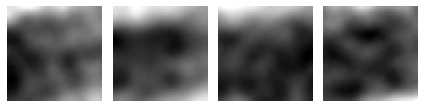

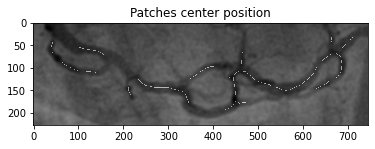

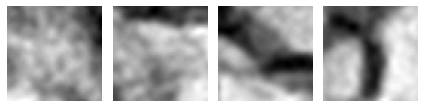

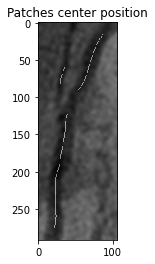

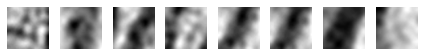

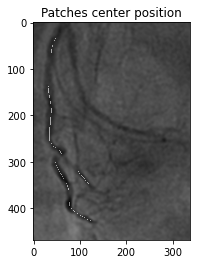

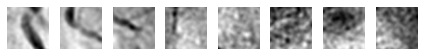

In [73]:
full_patches = extract_all_patches(available_arteries, all_boxes, [64, 64, 64, 64], [4, 4, 8, 8], rnd=0.2, debug=True)

In [13]:
print(np.shape(full_patches))

(3, 2)


---